# Practicum 2: Supply I

We talked today about how electricity markets work.

We will learn today how to simplify hourly data from electricity markets.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries.

Compared to day 1, we will be adding the the clustering k-means library from skit-learn.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import statsmodels.formula.api as smf

In [2]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day2/practicum/"

We load the data using the CSV syntax into a data frame called `df`.  Here we need to do some cleaning of the variables, rescaling and dropping missing entries. Make sure the data is in the same directory as the notebook or specify the full path name.

In [3]:
# We read the data and clean it up a bit
df = pd.read_csv(dirpath+"data_jaere.csv")

# Julia: df = sort(df,["year","month","day","hour"])
df = df.sort_values(["year", "month", "day", "hour"]).reset_index(drop=True)

# Julia: df = dropmissing(df)
df = df.dropna().reset_index(drop=True)

# Julia scaling: divide selected columns by 1000.0
scale_cols = ["nuclear", "hydro", "imports", "q_commercial", "q_industrial", "q_residential"]
for c in scale_cols:
    df[c] = df[c] / 1000.0

# Julia: df.hydronuc = df.nuclear + df.hydro
df["hydronuc"] = df["nuclear"] + df["hydro"]

# Julia: df = select(df,Not(["nuclear","hydro"]))
df = df.drop(columns=["nuclear", "hydro"])

df.head()

,year,month,day,hour,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc
0,2011,1,2,1,29.539724,4.502,8.380014,2.056590,10.640396,0.019787,0.0,6.558
1,2011,1,2,2,27.968777,4.363,8.347886,2.065578,9.803536,0.022171,0.0,6.455
2,2011,1,2,3,26.525766,4.089,8.548085,2.118515,9.555400,0.026903,0.0,6.453
3,2011,1,2,4,25.587187,3.783,8.560023,2.134670,9.310307,0.026979,0.0,6.407
4,2011,1,2,5,25.922943,3.969,8.612511,2.174985,9.428504,0.031043,0.0,6.564


In [4]:
df.describe()

,year,month,day,hour,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc
count,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000,43408.000000
mean,2013.002672,6.547802,15.748641,12.506381,35.543349,7.414221,12.109657,3.913436,10.598792,0.323496,0.185062,4.531600
std,1.413673,3.443493,8.771156,6.914164,12.687191,1.421009,2.656535,1.088283,3.011790,0.192717,0.266838,1.875999
min,2011.000000,1.000000,1.000000,1.000000,-13.939477,1.571000,6.916115,1.952891,3.870656,0.006894,0.000000,0.415000
25%,2012.000000,4.000000,8.000000,7.000000,27.302945,6.424000,10.037285,3.116492,8.496133,0.168279,0.000000,3.255000
50%,2013.000000,7.000000,16.000000,13.000000,34.571335,7.446000,11.458013,3.654409,9.820297,0.301532,0.000000,3.951000
75%,2014.000000,10.000000,23.000000,18.000000,42.530236,8.444250,13.681818,4.479459,12.158117,0.460613,0.367737,5.498000
max,2015.000000,12.000000,31.000000,24.000000,172.352220,11.674000,26.013323,8.531451,24.983059,0.949153,0.984559,10.824000


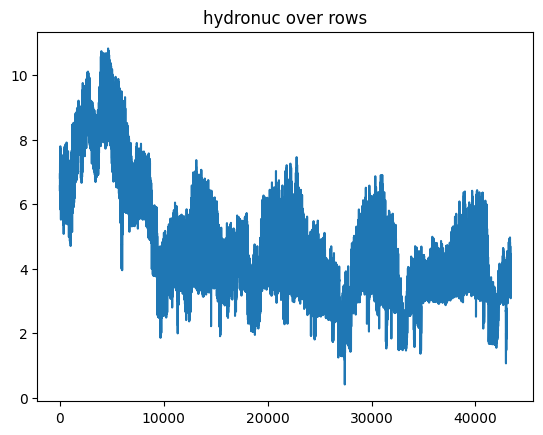

In [5]:
plt.figure()
plt.plot(np.arange(len(df)), df["hydronuc"].to_numpy())
plt.title("hydronuc over rows")
plt.show()

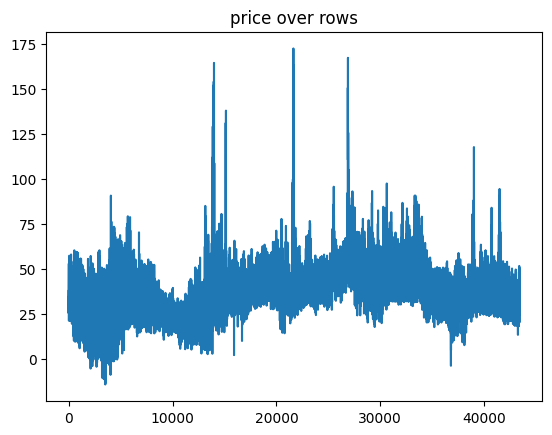

In [6]:
plt.figure()
plt.plot(np.arange(len(df)), df["price"].to_numpy())
plt.title("price over rows")
plt.show()

## Clustering our data

When modeling electricity markets, oftentimes the size of the problem can make the solver slow.

Here we will be using a clustering algorithm to come up with a (much) smaller synthetic dataset that we will use for the purposes of our main analysis.

**Note:** We ignore the time variables when we cluster.

In [16]:
n = 100 # number of clusters

cols = ["price", "imports", "q_commercial", "q_industrial", "q_residential",
        "wind_cap", "solar_cap", "hydronuc"]

X = df[cols].to_numpy()  # shape: (T, p)

# Compute standardized data
mu = X.mean(axis=0)      # mean per column (variable)
sig = X.std(axis=0, ddof=0)  # std per column (variable), like Julia's default std on arrays
Xs = (X - mu) / sig

# Compute k-means on standardized data
kmeans = KMeans(n_clusters=n, random_state=2020, n_init=10)
labels = kmeans.fit_predict(Xs)

# Re-center and scale data
centers_scaled = kmeans.cluster_centers_          # (n, p)
centers = centers_scaled * sig + mu               # (n, p)


In [17]:
centers

array([[2.76085670e+01, 6.96838732e+00, 1.36571811e+01, 4.92569296e+00,
        7.77287949e+00, 1.48912563e-01, 4.12209860e-01, 2.97826232e+00],
       [5.84129232e+01, 8.63597992e+00, 1.26210419e+01, 4.78694593e+00,
        1.58343013e+01, 3.43189306e-01, 6.92017685e-02, 4.71622490e+00],
       [3.06966827e+01, 7.57078312e+00, 9.72144417e+00, 3.32262805e+00,
        8.32887621e+00, 3.25299865e-01, 7.38182132e-03, 3.09976788e+00],
       [3.14380667e+01, 7.91359508e+00, 1.04610212e+01, 2.74462725e+00,
        1.27812978e+01, 1.17349177e-01, 2.99932438e-02, 6.56979418e+00],
       [4.28224388e+01, 9.38339714e+00, 1.89997706e+01, 3.91288896e+00,
        1.13869775e+01, 2.29714520e-01, 6.66392971e-01, 8.98084286e+00],
       [2.19880759e+01, 5.14704360e+00, 9.76471259e+00, 2.73317665e+00,
        8.65528786e+00, 1.87067267e-01, 5.29655274e-03, 5.75715395e+00],
       [3.47351845e+01, 8.06582855e+00, 1.06464402e+01, 3.26848808e+00,
        1.24004318e+01, 1.33717926e-01, 1.25193237e-02, 3.

In [18]:
dfclust = pd.DataFrame(centers, columns=cols)

# counts per label:
weights = np.bincount(labels, minlength=n)
dfclust["weights"] = weights

dfclust.head()

,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights
0,27.608567,6.968387,13.657181,4.925693,7.772879,0.148913,0.412210,2.978262,568
1,58.412923,8.635980,12.621042,4.786946,15.834301,0.343189,0.069202,4.716225,249
2,30.696683,7.570783,9.721444,3.322628,8.328876,0.325300,0.007382,3.099768,852
3,31.438067,7.913595,10.461021,2.744627,12.781298,0.117349,0.029993,6.569794,447
4,42.822439,9.383397,18.999771,3.912889,11.386978,0.229715,0.666393,8.980843,350


In [19]:
dfclust["weights"].describe()

count     100.000000
mean      434.080000
std       202.570186
min        13.000000
25%       289.500000
50%       406.000000
75%       564.250000
max      1007.000000
Name: weights, dtype: float64

In [20]:
sum(dfclust.weights)

43408

We can compare the distribution of outcomes between the original dataset and the new dataset. *Very important to use weights.*

In [21]:
def weighted_hist(ax, x, bins=20, weights=None, label=None, alpha=0.2):
    ax.hist(x, bins=bins, weights=weights, alpha=alpha, label=label)


Here is an example with prices. The two distributions are very similar.

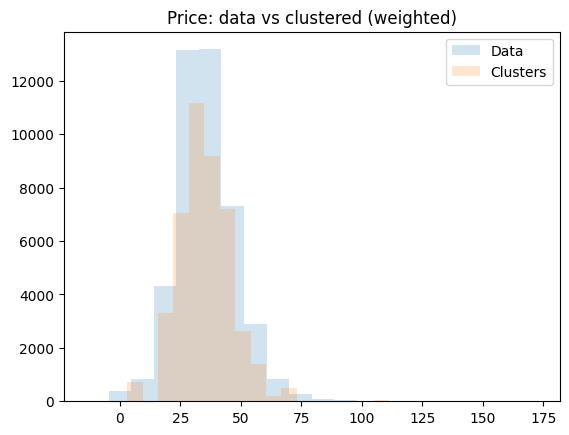

In [22]:
fig, ax = plt.subplots()
weighted_hist(ax, df["price"].to_numpy(), bins=20, weights=None, label="Data", alpha=0.2)
weighted_hist(ax, dfclust["price"].to_numpy(), bins=20, weights=dfclust["weights"].to_numpy(), label="Clusters", alpha=0.2)
ax.legend()
ax.set_title("Price: data vs clustered (weighted)")
plt.show()

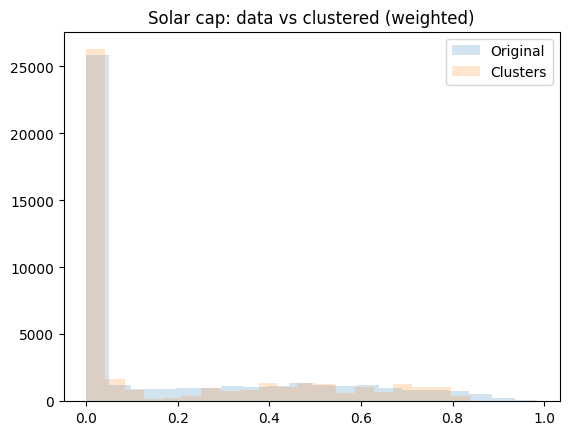

In [14]:
fig, ax = plt.subplots()
weighted_hist(ax, df["solar_cap"].to_numpy(), bins=20, weights=None, label="Original", alpha=0.2)
weighted_hist(ax, dfclust["solar_cap"].to_numpy(), bins=20, weights=dfclust["weights"].to_numpy(), label="Clusters", alpha=0.2)
ax.legend()
ax.set_title("Solar cap: data vs clustered (weighted)")
plt.show()

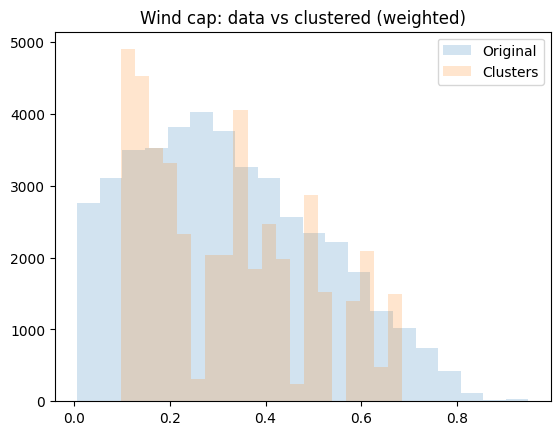

In [23]:
fig, ax = plt.subplots()
weighted_hist(ax, df["wind_cap"].to_numpy(), bins=20, weights=None, label="Original", alpha=0.2)
weighted_hist(ax, dfclust["wind_cap"].to_numpy(), bins=20, weights=dfclust["weights"].to_numpy(), label="Clusters", alpha=0.2)
ax.legend()
ax.set_title("Wind cap: data vs clustered (weighted)")
plt.show()

We can also check that the correlation between the main variables of interest remains similar.


In [24]:
pair_cols = ["price", "imports", "wind_cap", "solar_cap"]

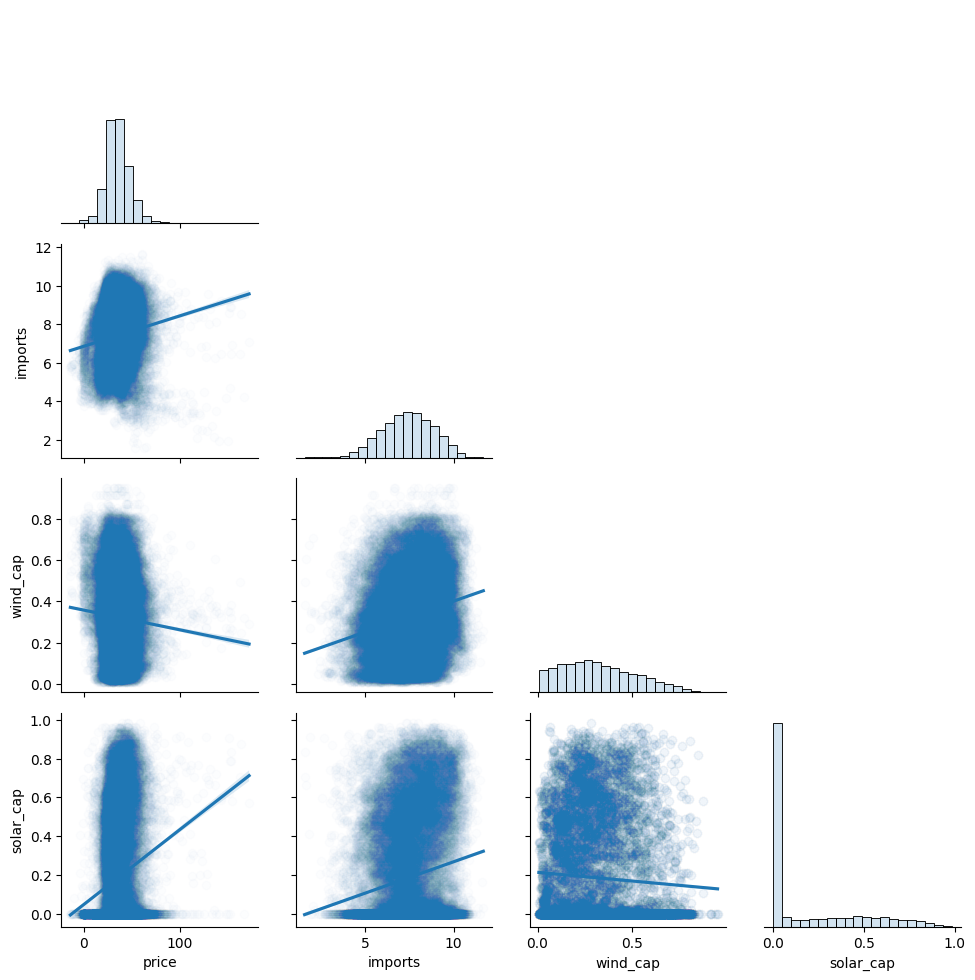

In [25]:
# with original data
g = sns.PairGrid(df[pair_cols], hue=None, corner=True)
g.map_diag(sns.histplot, bins=20, alpha=0.2)
g.map_lower(sns.regplot, truncate=True, scatter_kws=dict(alpha=0.01))
plt.show()

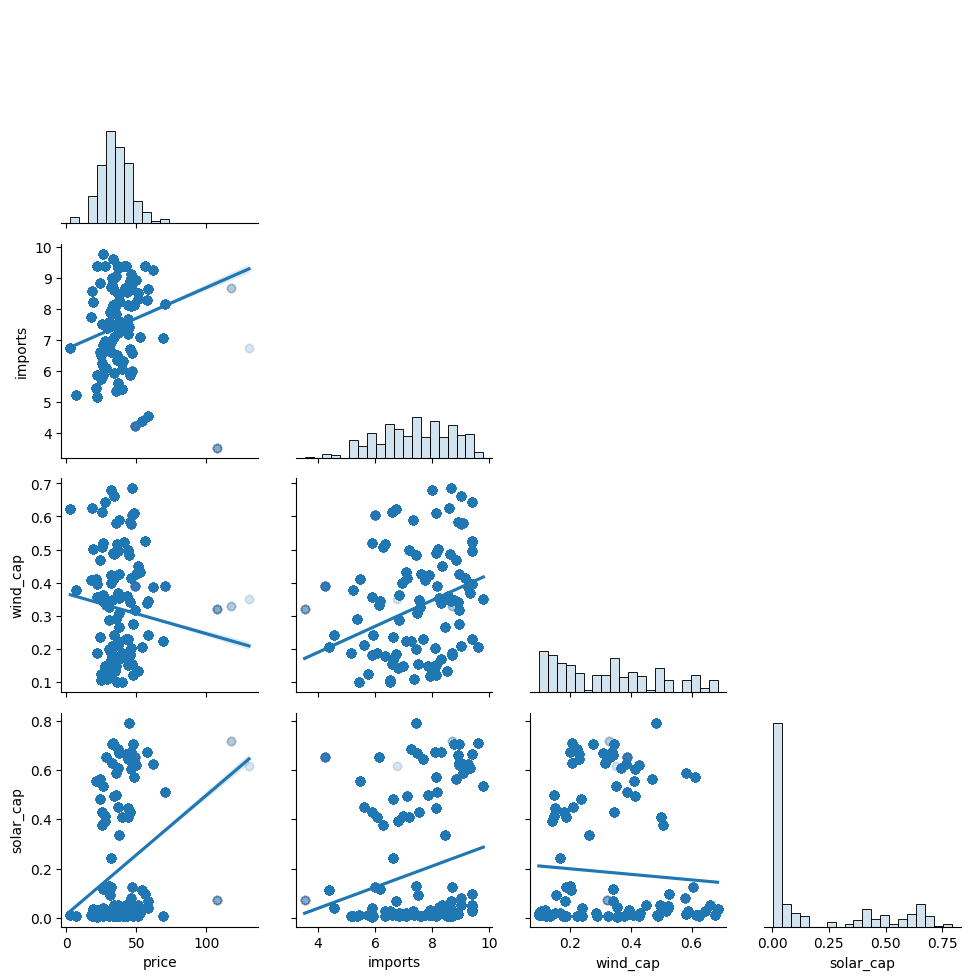

In [26]:
# We do a weighted version with the synthetic data    
dfclust_expanded = dfclust.loc[dfclust.index.repeat(dfclust["weights"])].reset_index(drop=True)
g = sns.PairGrid(dfclust_expanded[pair_cols], hue=None, corner=True)
g.map_diag(sns.histplot, bins=20, alpha=0.2)
g.map_lower(sns.regplot, truncate=True, scatter_kws=dict(alpha=0.01))
plt.show()

We can visualize the correlations directly, allowing for a correction for weights. 

We can see that the overall correlation patterns are quite good, capturing mot of the relationships in the data accurately.

In [27]:
# Original correlation matrix
MatOriginal = df[pair_cols].corr().to_numpy()
print(MatOriginal)

[[ 1.          0.1410854  -0.06288405  0.18312315]
 [ 0.1410854   1.          0.22139257  0.17209564]
 [-0.06288405  0.22139257  1.         -0.06477185]
 [ 0.18312315  0.17209564 -0.06477185  1.        ]]


In [28]:
# Synthetic data correlation matrix (expanded to account for weights)
MatClust_expanded = dfclust_expanded[pair_cols].corr().to_numpy()
print(MatClust_expanded)

[[ 1.          0.18066477 -0.08224331  0.22083338]
 [ 0.18066477  1.          0.29249892  0.21432671]
 [-0.08224331  0.29249892  1.         -0.07579896]
 [ 0.22083338  0.21432671 -0.07579896  1.        ]]


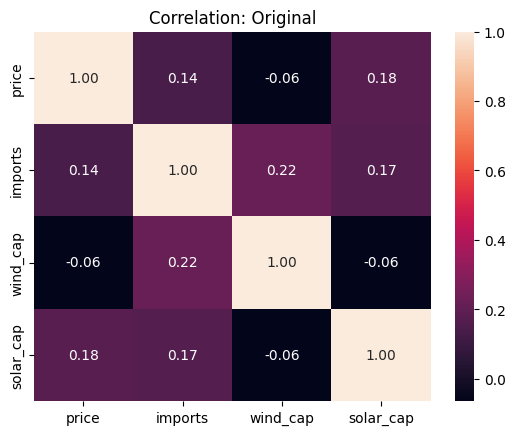

In [29]:
plt.figure()
sns.heatmap(MatOriginal, xticklabels=pair_cols, yticklabels=pair_cols, annot=True, fmt=".2f")
plt.title("Correlation: Original")
plt.show()

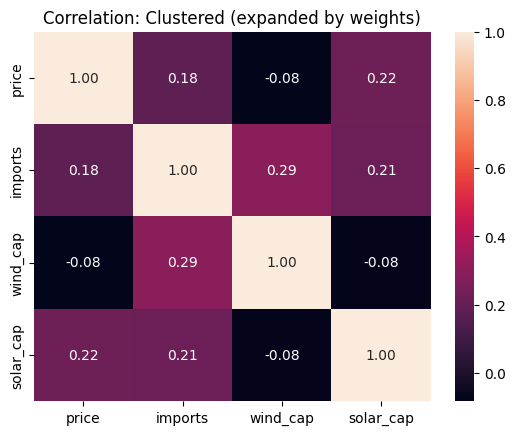

In [30]:
plt.figure()
sns.heatmap(MatClust_expanded, xticklabels=pair_cols, yticklabels=pair_cols, annot=True, fmt=".2f")
plt.title("Correlation: Clustered (expanded by weights)")
plt.show()

*Side note:* These are raw correlations. We can check how the correlation of solar and price depend on controls.

In [31]:
reg_nocontrols = smf.ols("price ~ solar_cap", data=df).fit()
print(reg_nocontrols.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1506.
Date:                Mon, 09 Feb 2026   Prob (F-statistic):          4.94e-324
Time:                        15:12:12   Log-Likelihood:            -1.7113e+05
No. Observations:               43408   AIC:                         3.423e+05
Df Residuals:                   43406   BIC:                         3.423e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.9320      0.073    465.751      0.0

In [32]:
reg_controls = smf.ols("price ~ solar_cap + q_commercial + q_residential + q_industrial", data=df).fit()
print(reg_controls.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     6123.
Date:                Mon, 09 Feb 2026   Prob (F-statistic):               0.00
Time:                        15:12:28   Log-Likelihood:            -1.6216e+05
No. Observations:               43408   AIC:                         3.243e+05
Df Residuals:                   43403   BIC:                         3.244e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.8913      0.309    -19.059

We save the clustered data.

In [64]:
outpath = f"{dirpath}data_jaere_clustered_{n}.csv"
dfclust.to_csv(outpath, index=False)
print("Wrote:", outpath)

Wrote: /Users/marreguant/Dropbox/TEACHING/BSE/Electricity2026/day2/practicum/data_jaere_clustered_500.csv


## Follow-up exercises

1. Perform the same clustering exercise with the wind data from Spain that we used last week.

2. Can you run regressions that give you a similar answer with as little as 100 or 200 observations? Note: It is essential that you use a *weighted regression*.
